In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
import seaborn as sns


import requests
from bs4 import BeautifulSoup
import os
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from tqdm import tqdm
import time

from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support

### Llamamos los fits estandarizados para la comprobacion

In [4]:
#archivos=['DataDESI_36.fits', 'DataDESI_72.fits', 'DataDESI_108.fits', 'DataDESI_144.fits', 'DataDESI_180.fits', 'DataDESI_216.fits'
 #, 'DataDESI_252.fits', 'DataDESI_288.fits', 'DataDESI_324.fits', 'DataDESI_360.fits', 'DataDESI_379.fits']
archivos=['DataDESI_216.fits', 'DataDESI_288.fits']

#Generamos las listas con los datos:
Spectra_set= None #Este tensor contiene los elementos de flujo completo R+Z+B
y=np.array([]) #Esta lsita contiene las etiquetas para el ejercicio de clasificacion
z=np.array([]) #Esta matriz contiene los corrimientos z para el ejercicio de regresion

for h in range(len(archivos)):
    espc = fits.open(archivos[h]) #open file
    len_espc= len(espc[2].data)
    
    #leemos la informacion
    Bflux=espc[2].data
    Zflux=espc[4].data
    Rflux=espc[3].data
    
    spectra=np.hstack((Bflux, Zflux, Rflux)) #Contiene la cadena completa de flujo B+Z+R para cada espectro
    spectra=spectra.reshape(spectra.shape[0], spectra.shape[1], 1)
    
    if Spectra_set is None:
        Spectra_set = spectra
    else:
        Spectra_set = np.concatenate((Spectra_set, spectra), axis=0)
    
    y=np.append(y, Table.read(espc, hdu=1)['SPECTYPE'].data)
    
    z=np.append(z, Table.read(espc, hdu=1)['Z'].data)
    z=z.reshape(-1,1)

#Tenemos el tensor Spectra_set que contiene todos los flujos de los .fits seleccionados
#y es una lista con las etiquetas de dichos espectros
#z una matriz con los valores de corrimiento de cada espectro.


### Leemos datos del archivo .fits pero unicamente de la clase de interes 'GALAXY', 'STAR', 'QSO'

In [35]:
from astropy.io import fits
from astropy.table import Table
import numpy as np

# Lista de archivos .fits
archivos=['DataDESI_216.fits', 'DataDESI_288.fits']

# Generamos las listas con los datos:
Spectra_set = None  # Este tensor contiene los elementos de flujo completo R+Z+B
y = np.array([])  # Esta lista contiene las etiquetas para el ejercicio de clasificación
z = np.array([])  # Esta matriz contiene los corrimientos z para el ejercicio de regresión

# Clase espectral específica que deseas seleccionar
clase_espectral_objetivo = 'GALAXY'

for h in range(len(archivos)):
    espc = fits.open(archivos[h])  # Abrir el archivo

    # Leer información
    Bflux = espc[2].data
    Zflux = espc[4].data
    Rflux = espc[3].data

    # Obtener la clase espectral para cada espectro
    clases_espectrales = Table.read(espc, hdu=1)['SPECTYPE'].data

    # Seleccionar solo los espectros de la clase espectral objetivo
    indices_objetivo = np.where(clases_espectrales == clase_espectral_objetivo)[0]

    # Filtrar los flujos, etiquetas y corrimientos
    Bflux_objetivo = Bflux[indices_objetivo]
    Zflux_objetivo = Zflux[indices_objetivo]
    Rflux_objetivo = Rflux[indices_objetivo]

    # Concatenar los flujos de los espectros objetivo
    spectra = np.hstack((Bflux_objetivo, Zflux_objetivo, Rflux_objetivo))
    spectra = spectra.reshape(spectra.shape[0], spectra.shape[1], 1)

    # Concatenar las etiquetas y corrimientos de los espectros objetivo
    y_objetivo = Table.read(espc, hdu=1)['SPECTYPE'].data[indices_objetivo]
    z_objetivo = Table.read(espc, hdu=1)['Z'].data[indices_objetivo]
    z_objetivo = z_objetivo.reshape(-1, 1)

    if Spectra_set is None:
        Spectra_set = spectra
    else:
        Spectra_set = np.concatenate((Spectra_set, spectra), axis=0)

    y = np.append(y, y_objetivo)
    z = np.append(z, z_objetivo)
    z=z.reshape(-1,1)
    
# Tenemos el tensor Spectra_set que contiene todos los flujos de los .fits seleccionados
# y es una lista con las etiquetas de dichos espectros
# z una matriz con los valores de corrimiento de cada espectro.

### Cargamos el modelo de regresion y comprobamos

### 1. Rregresion QSO

In [24]:
# Cargar el modelo desde el archivo HDF5
loaded_model = load_model("mi_modelo_regresion_QSO.h5")

# Hacer predicciones sobre la nueva muestra de datos
predictions_new = loaded_model.predict(Spectra_set)


275/275 [==============================] - 452s 2s/step


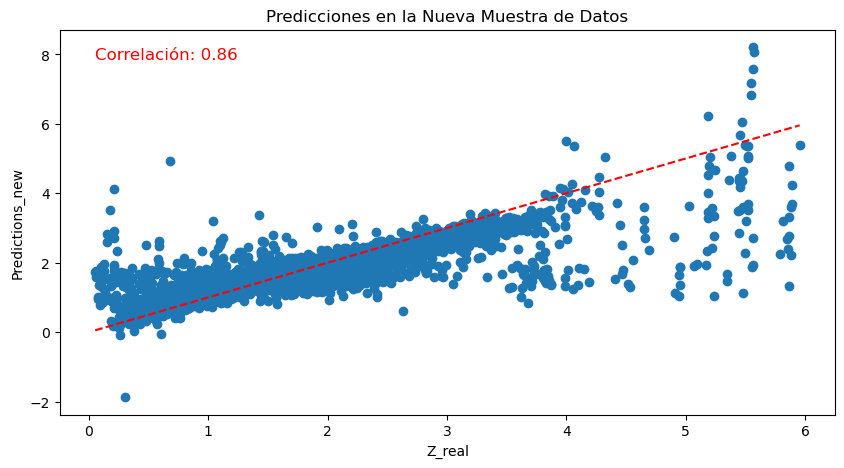

In [25]:
# Eliminar filas con NaN
mask = ~np.isnan(z) & ~np.isnan(predictions_new)
z_cleaned = z[mask]
predictions_cleaned = predictions_new[mask]

# Tomar una muestra aleatoria
sample_size = min(100000, len(z_cleaned))  # Revisamos que el tamaño de la muestra no sea mayor que la longitud de los datos
indices = np.random.choice(len(z_cleaned), sample_size, replace=False)
z_sample = z_cleaned[indices]
predictions_sample = predictions_cleaned[indices]

# Calculamos la correlación en la muestra
correlation_coefficient = np.corrcoef(z_sample, predictions_sample)[0, 1]

# Visualizar las predicciones en la nueva muestra de datos
plt.figure(figsize=(10, 5))
plt.scatter(z_cleaned, predictions_cleaned)
x_line = np.linspace(min(z_cleaned), max(z_cleaned), 100)  # Crear puntos para la línea
y_line = x_line  # Pendiente 1
plt.plot(x_line, y_line, color='red', linestyle='--')
plt.title("Predicciones en la Nueva Muestra de Datos")
plt.xlabel("Z_real")
plt.ylabel("Predictions_new")

# Mostrar la correlación en el gráfico
plt.text(min(z_cleaned), max(predictions_cleaned), f'Correlación: {correlation_coefficient:.2f}', verticalalignment='top', horizontalalignment='left', color='red', fontsize=12)

plt.show()





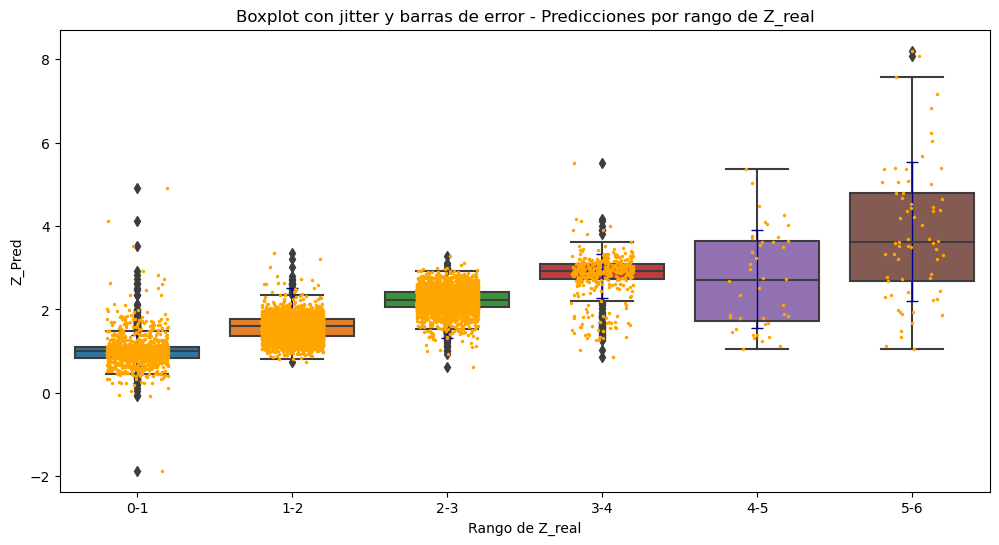

In [31]:
# Asegurémonos de que ambos z y predictions_new sean arrays unidimensionales
z_flat = np.ravel(z)
predictions_flat = np.ravel(predictions_new)

# Crear DataFrame con los datos
data = pd.DataFrame({'Z_real': z_flat, 'Z_Pred': predictions_flat})

# Dividir Z en rangos
bins = [0, 1, 2, 3, 4, 5, 6]  # Define los límites de los rangos
labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6']  # Etiquetas para los rangos
data['range_Z'] = pd.cut(data['Z_real'], bins=bins, labels=labels, include_lowest=True)

# Crear el gráfico boxplot con jitter
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='range_Z', y='Z_Pred', data=data)
ax = sns.stripplot(x='range_Z', y='Z_Pred', data=data, color="orange", jitter=0.2, size=2.5)

# Añadir barras de error
for i, value in enumerate(data['range_Z'].unique()):
    subset = data[data['range_Z'] == value]
    plt.errorbar(i, subset['Z_Pred'].mean(), yerr=subset['Z_Pred'].std(), fmt='none', ecolor='darkblue', elinewidth=1, capsize=4)

# Añadir etiquetas y título
plt.title("Boxplot con jitter y barras de error - Predicciones por rango de Z_real")
plt.xlabel("Rango de Z_real")
plt.ylabel("Z_Pred")

# Mostrar el gráfico
plt.show()


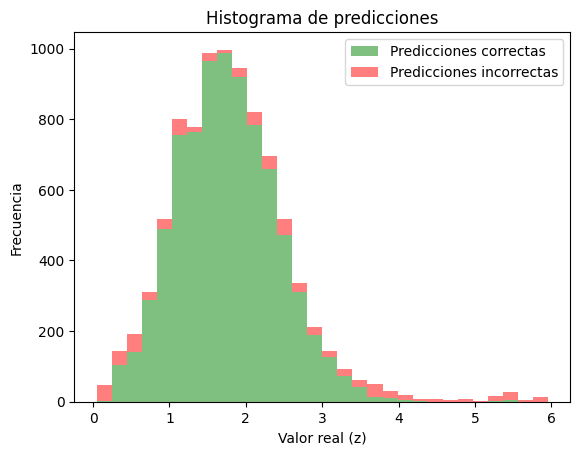

In [34]:
# Calcular la diferencia entre las predicciones y los valores reales
diferencia = np.abs(predictions_new - z)
# Definir un umbral para determinar si la predicción es correcta (por ejemplo, 0.1 unidades de diferencia)
umbral = 0.5
predicciones_correctas = np.where(diferencia <= umbral, 1, 0)

# Crear un histograma de barras apiladas
plt.hist([z[predicciones_correctas == 1].flatten(), z[predicciones_correctas == 0].flatten()],
         bins=30, alpha=0.5, label=['Predicciones correctas', 'Predicciones incorrectas'], color=['green', 'red'], stacked=True)

# Configurar etiquetas y título
plt.xlabel('Valor real (z)')
plt.ylabel('Frecuencia')
plt.title('Histograma de predicciones')

# Mostrar leyenda
plt.legend()

# Mostrar el histograma
plt.show()

### 2. Rregresion STAR

In [33]:
# Cargar el modelo desde el archivo HDF5
loaded_model = load_model("mi_modelo_regresion_STAR.h5")

# Hacer predicciones sobre la nueva muestra de datos
predictions_new = loaded_model.predict(Spectra_set)


189/189 [==============================] - 291s 2s/step


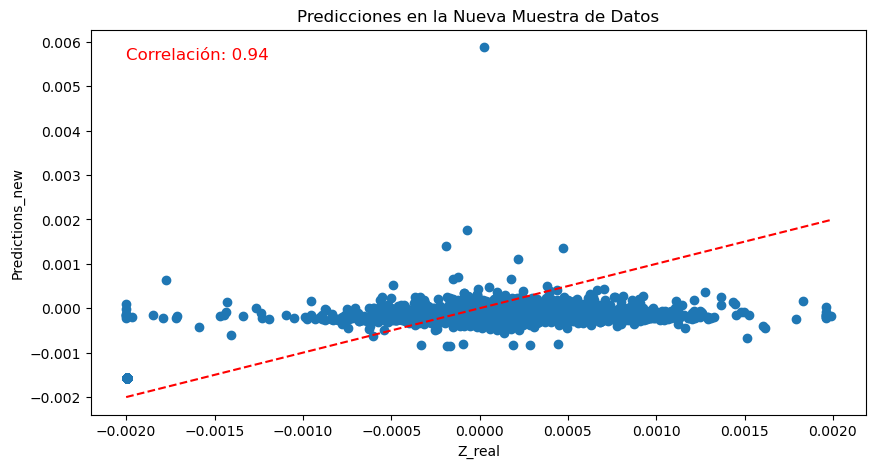

In [24]:
# Eliminar filas con NaN
mask = ~np.isnan(z) & ~np.isnan(predictions_new)
z_cleaned = z[mask]
predictions_cleaned = predictions_new[mask]

# Tomar una muestra aleatoria
sample_size = min(100000, len(z_cleaned))  # Asegurarse de que el tamaño de la muestra no sea mayor que la longitud de los datos
indices = np.random.choice(len(z_cleaned), sample_size, replace=False)
z_sample = z_cleaned[indices]
predictions_sample = predictions_cleaned[indices]

# Calcular la correlación en la muestra
correlation_coefficient = np.corrcoef(z_sample, predictions_sample)[0, 1]

# Visualizar las predicciones en la nueva muestra de datos
plt.figure(figsize=(10, 5))
plt.scatter(z_cleaned, predictions_cleaned)
x_line = np.linspace(min(z_cleaned), max(z_cleaned), 100)  # Crear puntos para la línea
y_line = x_line  # Pendiente 1
plt.plot(x_line, y_line, color='red', linestyle='--')
plt.title("Predicciones en la Nueva Muestra de Datos")
plt.xlabel("Z_real")
plt.ylabel("Predictions_new")

# Mostrar la correlación en el gráfico
plt.text(min(z_cleaned), max(predictions_cleaned), f'Correlación: {correlation_coefficient:.2f}', verticalalignment='top', horizontalalignment='left', color='red', fontsize=12)

plt.show()

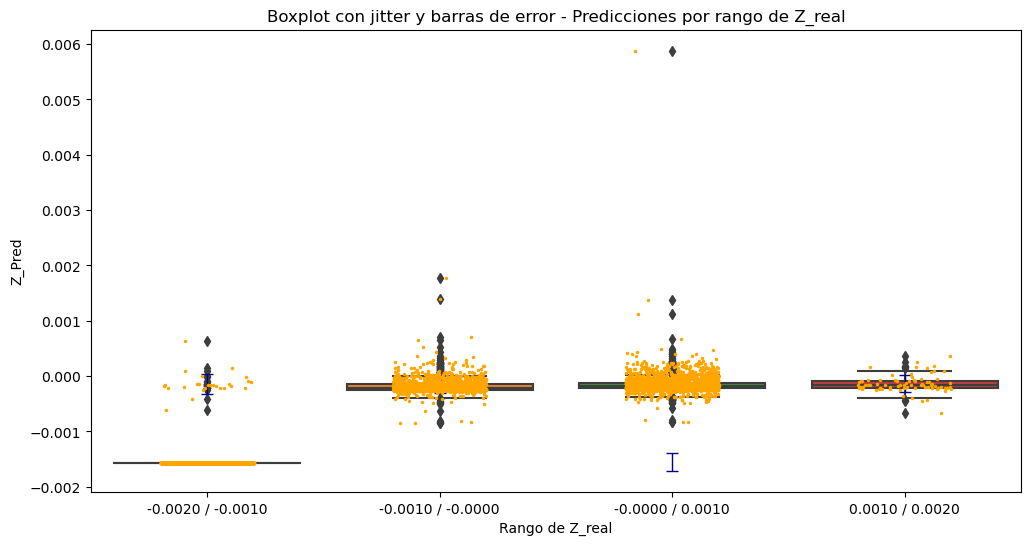

In [34]:
# Asegurémonos de que ambos z y predictions_new sean arrays unidimensionales
z_flat = np.ravel(z)
predictions_flat = np.ravel(predictions_new)

# Crear DataFrame con los datos
data = pd.DataFrame({'Z_real': z_flat, 'Z_Pred': predictions_flat})

# Dividir Z en rangos
bins = [-0.0020, -0.0010, 0.0000, 0.0010, 0.0020]  # Define los límites de los rangos
labels = ['-0.0020 / -0.0010', '-0.0010 / -0.0000', '-0.0000 / 0.0010', '0.0010 / 0.0020']  # Etiquetas para los rangos
data['range_Z'] = pd.cut(data['Z_real'], bins=bins, labels=labels, include_lowest=True)

# Crear el gráfico boxplot con jitter
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='range_Z', y='Z_Pred', data=data)
ax = sns.stripplot(x='range_Z', y='Z_Pred', data=data, color="orange", jitter=0.2, size=2.5)

# Añadir barras de error
for i, value in enumerate(data['range_Z'].unique()):
    subset = data[data['range_Z'] == value]
    plt.errorbar(i, subset['Z_Pred'].mean(), yerr=subset['Z_Pred'].std(), fmt='none', ecolor='darkblue', elinewidth=1, capsize=4)

# Añadir etiquetas y título
plt.title("Boxplot con jitter y barras de error - Predicciones por rango de Z_real")
plt.xlabel("Rango de Z_real")
plt.ylabel("Z_Pred")

# Mostrar el gráfico
plt.show()


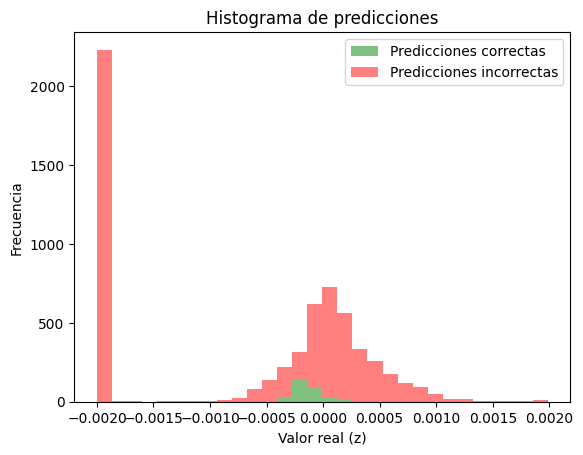

In [30]:
# Calcular la diferencia entre las predicciones y los valores reales
diferencia = np.abs(predictions_new - z)
# Definir un umbral para determinar si la predicción es correcta (por ejemplo, 0.1 unidades de diferencia)
umbral = 0.00005
predicciones_correctas = np.where(diferencia <= umbral, 1, 0)

# Crear un histograma de barras apiladas
plt.hist([z[predicciones_correctas == 1].flatten(), z[predicciones_correctas == 0].flatten()],
         bins=30, alpha=0.5, label=['Predicciones correctas', 'Predicciones incorrectas'], color=['green', 'red'], stacked=True)

# Configurar etiquetas y título
plt.xlabel('Valor real (z)')
plt.ylabel('Frecuencia')
plt.title('Histograma de predicciones')

# Mostrar leyenda
plt.legend()

# Mostrar el histograma
plt.show()

### 3. Rregresion galaxy

In [36]:
# Cargar el modelo desde el archivo HDF5
loaded_model = load_model("mi_modelo_regresion_GALAXY.h5")

# Hacer predicciones sobre la nueva muestra de datos
predictions_new = loaded_model.predict(Spectra_set)


3846/3846 [==============================] - 4763s 1s/step


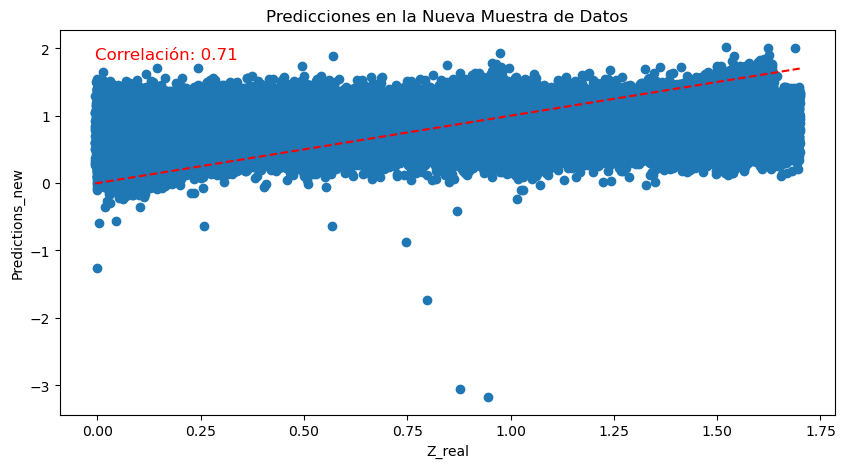

In [37]:
# Eliminar filas con NaN
mask = ~np.isnan(z) & ~np.isnan(predictions_new)
z_cleaned = z[mask]
predictions_cleaned = predictions_new[mask]

# Tomar una muestra aleatoria
sample_size = min(10000, len(z_cleaned))  # Asegurarse de que el tamaño de la muestra no sea mayor que la longitud de los datos
indices = np.random.choice(len(z_cleaned), sample_size, replace=False)
z_sample = z_cleaned[indices]
predictions_sample = predictions_cleaned[indices]

# Calcular la correlación en la muestra
correlation_coefficient = np.corrcoef(z_sample, predictions_sample)[0, 1]

# Visualizar las predicciones en la nueva muestra de datos
plt.figure(figsize=(10, 5))
plt.scatter(z_cleaned, predictions_cleaned)
x_line = np.linspace(min(z_cleaned), max(z_cleaned), 100)  # Crear puntos para la línea
y_line = x_line  # Pendiente 1
plt.plot(x_line, y_line, color='red', linestyle='--')
plt.title("Predicciones en la Nueva Muestra de Datos")
plt.xlabel("Z_real")
plt.ylabel("Predictions_new")

# Mostrar la correlación en el gráfico
plt.text(min(z_cleaned), max(predictions_cleaned), f'Correlación: {correlation_coefficient:.2f}', verticalalignment='top', horizontalalignment='left', color='red', fontsize=12)

plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


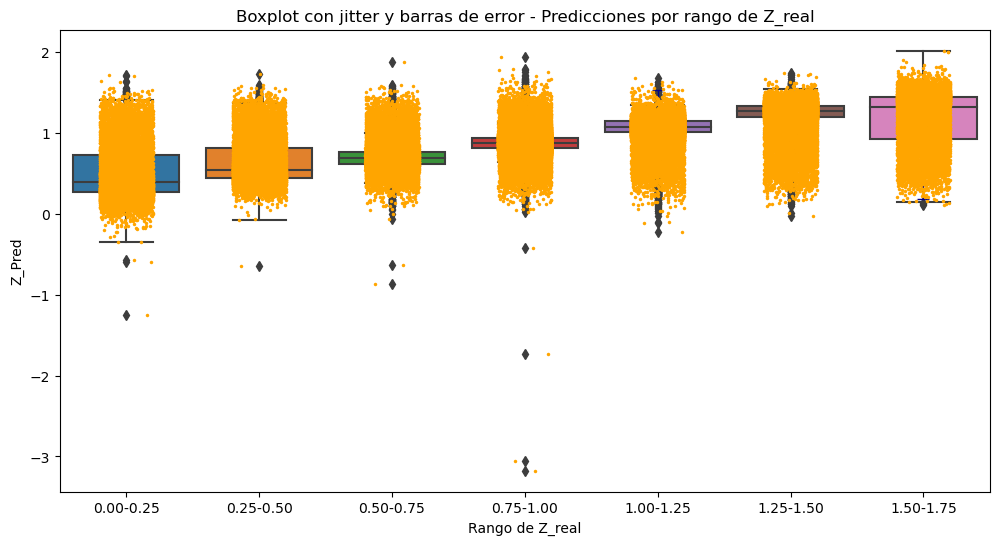

In [38]:
# Asegurémonos de que ambos z y predictions_new sean arrays unidimensionales
z_flat = np.ravel(z)
predictions_flat = np.ravel(predictions_new)

# Crear DataFrame con los datos
data = pd.DataFrame({'Z_real': z_flat, 'Z_Pred': predictions_flat})

# Dividir Z en rangos
bins = [0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75]  # Define los límites de los rangos
labels = ['0.00-0.25', '0.25-0.50', '0.50-0.75', '0.75-1.00', '1.00-1.25','1.25-1.50', '1.50-1.75']  # Etiquetas para los rangos
data['range_Z'] = pd.cut(data['Z_real'], bins=bins, labels=labels, include_lowest=True)

# Crear el gráfico boxplot con jitter
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='range_Z', y='Z_Pred', data=data)
ax = sns.stripplot(x='range_Z', y='Z_Pred', data=data, color="orange", jitter=0.2, size=2.5)

# Añadir barras de error
for i, value in enumerate(data['range_Z'].unique()):
    subset = data[data['range_Z'] == value]
    plt.errorbar(i, subset['Z_Pred'].mean(), yerr=subset['Z_Pred'].std(), fmt='none', ecolor='darkblue', elinewidth=1, capsize=4)

# Añadir etiquetas y título
plt.title("Boxplot con jitter y barras de error - Predicciones por rango de Z_real")
plt.xlabel("Rango de Z_real")
plt.ylabel("Z_Pred")

# Mostrar el gráfico
plt.show()


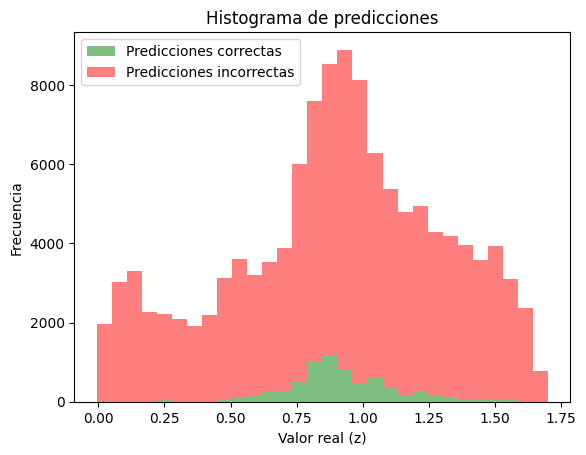

In [39]:
# Calcular la diferencia entre las predicciones y los valores reales
diferencia = np.abs(predictions_new - z)
# Definir un umbral para determinar si la predicción es correcta (por ejemplo, 0.1 unidades de diferencia)
umbral = 0.005
predicciones_correctas = np.where(diferencia <= umbral, 1, 0)

# Crear un histograma de barras apiladas
plt.hist([z[predicciones_correctas == 1].flatten(), z[predicciones_correctas == 0].flatten()],
         bins=30, alpha=0.5, label=['Predicciones correctas', 'Predicciones incorrectas'], color=['green', 'red'], stacked=True)

# Configurar etiquetas y título
plt.xlabel('Valor real (z)')
plt.ylabel('Frecuencia')
plt.title('Histograma de predicciones')

# Mostrar leyenda
plt.legend()

# Mostrar el histograma
plt.show()

### Cargamos el modelo de clasifiacion y comprobamos

In [6]:
y = np.array(y)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_categorical = to_categorical(y)

# Cargar el modelo desde el archivo HDF5
loaded_model = load_model("mi_modelo_clasifiacion_1.h5")

# Hacer predicciones sobre la nueva muestra de datos
predictions_new = loaded_model.predict(Spectra_set)    #GALAXY=0, QSO=1, STAR=2

4309/4309 [==============================] - 161s 37ms/step


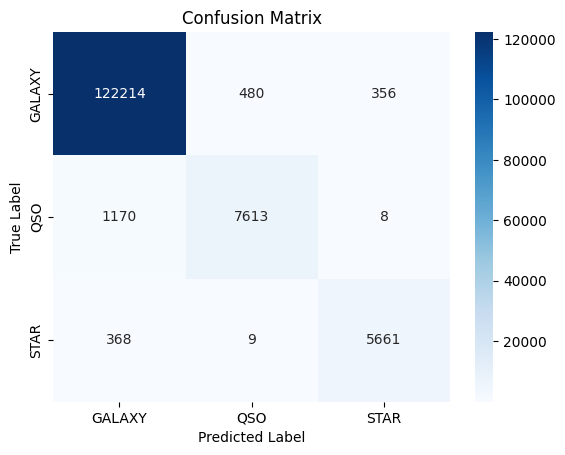

In [7]:
# Obtener las etiquetas reales y predichas
true_labels = np.argmax(y_categorical, axis=1)
predicted_labels = np.argmax(predictions_new, axis=1)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión con seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['GALAXY', 'QSO', 'STAR'], yticklabels=['GALAXY', 'QSO', 'STAR'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Calcular precision, recall, y F1 Score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

Precision: 0.9824
Recall: 0.9827
F1 Score: 0.9824


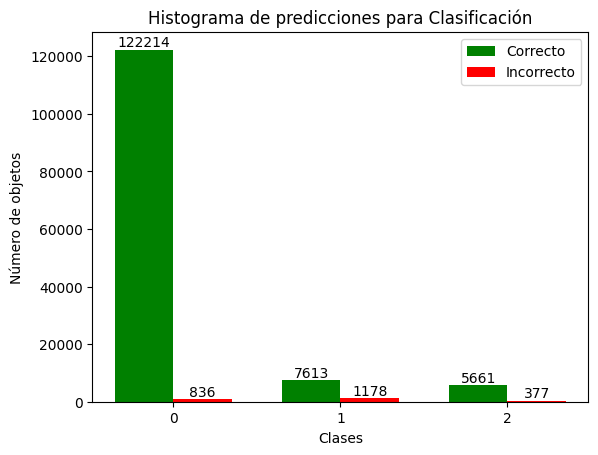

In [15]:
# Crear un diccionario para contar las clasificaciones correctas e incorrectas por clase
correct_counts = {0: 0, 1: 0, 2: 0}
incorrect_counts = {0: 0, 1: 0, 2: 0}

for true_label, predicted_label in zip(true_labels, predicted_labels):
    if true_label == predicted_label:
        correct_counts[true_label] += 1
    else:
        incorrect_counts[true_label] += 1

# Crear un histograma
classes = [0, 1, 2]
correct_values = [correct_counts[c] for c in classes]
incorrect_values = [incorrect_counts[c] for c in classes]

bar_width = 0.35
index = np.arange(len(classes))

plt.bar(index, correct_values, bar_width, label='Correcto', color='green')
plt.bar(index + bar_width, incorrect_values, bar_width, label='Incorrecto', color='red')

# Agregar etiquetas con la frecuencia encima de cada barra
for i, value in enumerate(correct_values):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom', color='black')

for i, value in enumerate(incorrect_values):
    plt.text(i + bar_width, value + 0.1, str(value), ha='center', va='bottom', color='black')

# Configurar etiquetas y título
plt.xlabel('Clases')
plt.ylabel('Número de objetos')
plt.title('Histograma de predicciones para Clasificación')
plt.xticks(index + bar_width / 2, classes)
plt.legend()

# Mostrar el histograma
plt.show()